# Weak Labels Models for Behavior Prediction under Distribution Shift

**Author:** Medha Agarwal | 
**Last Modified:** December 03, 2025

This notebook demonstrates **domain adaptation** for wildlife behavior prediction to address the **distribution shift** between the source (labeled) data and the target (unlabeled & weakly labeled) data.

We employ **FixMatch**, a semi-supervised learning method that leverages both labeled data from Vectronics and **weakly-labeled data** from the RVC dataset. 

The notebook covers the following key steps:
1.  **STEP 1. Load data** Loading and transforming raw sensor features
2.  **STEP 2. Training models** Training the FixMatch domain adaptation model
3.  **STEP 3. Model evaluation** Assessing performance via predictions on held-out laeled source and target samples
4.  **STEP 4. Calibration** Calibrating the prediction scores to satisfy a pre-determined label distribution
5.  **STEP 5. Prediction and saving outputs** Saving the uncalibrated and calibrated prediction scores

The notebook expects the following preprocessed data files to be available in the `data/` directory:

* `Vectronics_preprocessed_duration30.0.csv` — generated by `scripts/run_Vectronics_preprocessing.py`
* `Vectronics_full_summary.csv` — generated by `scripts/run_Vectronics_preprocessing.py`
* `RVC_preprocessed.csv` — generated by `scripts/run_RVC_preprocessing.py`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import modules
import sys
sys.path.append(".")
sys.path.append("../")
sys.path.append("../../")
import os
import yaml
import json
import numpy as np
import pandas as pd
from dataclasses import dataclass, field, asdict
from typing import List, Optional

import torch
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:
# Script imports

import config as config

# utility functions
import src.utils.io as io
import src.utils.preprocess as preprocess
from src.utils.data_prep import setup_multilabel_dataloaders
import src.utils.datasets as datasets
from src.utils.train import train_fixmatch
from src.utils.Vectronics_preprocessing import modify_vectronics_labels
from src.utils.plots import multi_label_predictions, plot_multiclass_roc, make_multilabel_confusion_matrices
import src.utils.functionalities as func

# method functions
from src.methods.coral import SimpleFeatureNet
from src.methods.calibration import calibration

# evaluation functions
from src.eval.eval_utils import evaluate_multilabel_distribution

In [4]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = False

In [5]:
np.random.seed(seed=0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

The arguments listed below define the complete set of configurable parameters for the ML pipeline. The `exp_name` argument should be set to a user-defined string. All training and evaluation results are saved in the directory:

```
results/domain_adaptation_training_results/{model_name}/{args.exp_name}_{timestamp}
```

* `timestamp` is automatically generated when creating the `root_dir` and follows the format `%Y-%m-%d_%H-%M-%S`.
* `model_name` is determined by `args.lambda_target`:

  * `fixmatch_semi_supervised` if `args.lambda_target > 0.0` (i.e., the model uses target weak labels during training)
  * `fixmatch_self_supervised` if `args.lambda_target == 0.0` (i.e., the model does not use target weak labels)

Users should adjust the arguments below according to their requirements and provide a descriptive `exp_name`. All argument values are also saved in the experiment directory in a file named `config.json` for reference and reproducibility.


In [6]:
@dataclass
class TrainConfig:
    # ---------------- Experiment ----------------
    exp_name: str = "DEFAULT"

    # ---------------- Feature setup ----------------
    pos_idx: Optional[List[int]] = field(
        default_factory=lambda: [0, 1, 2, 3, 4, 5]
    )
    center_idx: Optional[List[int]] = None
    source_padding_duration: Optional[float] = None

    # ---------------- Preprocessing ----------------
    keep_confidence_levels: Optional[List[str]] = None # optionally give a list of confidence levels to retain like ['H', 'M']
    eating_to_other: Optional[List[str]] = None # optionally give a list of eating levels to convert to Other like ['H', 'M']
    eating_to_exclude: Optional[List[str]] = None # optionally give a list of confidence levels to remove from eating like ['H', 'M']
    n_sample_per_target: int = 200_000

    # ---------------- Model ----------------
    feat_dim: int = 128
    fixmatch_threshold: float = 0.95
    lambda_target: float = 1.0
    lambda_unsup: float = 0.0

    # ---------------- Training ----------------
    theta: float = 0.3
    num_epochs: int = 200
    batch_size: int = 512
    learning_rate: float = 1e-3
    weight_decay: float = 0.0
    source_test_frac: float = 0.2
    target_val_frac: float = 0.25
    target_test_frac: float = 0.25

    # ---------------- Output ----------------
    device: int = 0
    seed: int = 0
    multilabel_threshold: float = 0.5

args = TrainConfig()

In [7]:
device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
if args.lambda_target == 0.0:
    root_dir = os.path.join(io.get_domain_adaptation_results_dir(), "fixmatch_self_supervised")
else:
    root_dir = os.path.join(io.get_domain_adaptation_results_dir(), "fixmatch_semi_supervised")
root_dir = io.get_exp_dir(output_root=root_dir, exp_name=args.exp_name)
os.makedirs(root_dir, exist_ok=True)
with open(os.path.join(root_dir, "config.json"), "w") as f:
    json.dump(asdict(args), f, indent=4, sort_keys=True)

## Step 1 — Load and Inspect Preprocessed Data

In this step, we load two preprocessed datasets:
(1) the **high-frequency Vectronics acceleration data** recorded at 16 Hz, and
(2) the **lower-frequency RVC behavioral data** that provides summarized measurements (over 30 seconds windows).

To ensure both datasets are comparable in scale, we apply **log-transformations** and **truncations** to key continuous variables and perform **initial visualization** to explore their marginal distributions. These plots reveal a **substantial distribution shift** between the source domain (Vectronics) and the target domain (RVC): a central challenge motivating our calibration and domain adaptation pipeline.

---

### 🟦 Vectronics Data (Source Domain)

Run the preprocessing script:

```
scripts/run_Vectronics_preprocessing.py
```

This script converts raw high-frequency data into summary statistics aggregated over **30-minute windows**, matching the resolution of the RVC data. The output is saved to:

```
data/Vectronics_preprocessed_duration30.0.csv
```

At the time of this notebook’s creation, this file is approximately **86 MB**.

Expected columns include:

| Helper Metadata Features (7)   | Summary Acceleration Features (9) |
| ------------------------------ | ------------------------- |
| animal_id                      | acc_x_mean                |
| UTC date [yyyy-mm-dd]          | acc_y_mean                |
| UTC time [yyyy-mm-dd HH:MM:SS] | acc_z_mean                |
| behavior                       | acc_x_ptp_max             |
| Source                         | acc_x_ptp_mean            |
| Confidence (H-M-L)             | acc_y_ptp_max             |
| Eating intensity               | acc_y_ptp_mean            |
|                                | acc_z_ptp_max             |
|                                | acc_z_ptp_mean            |

---

### 🟥 RVC Data (Target Domain)

Run the preprocessing script:

```
scripts/run_RVC_preprocessing.py
```

This script:

* Combines raw data files,
* Performs calibration using collar metadata,
* Removes outliers and invalid observations.

The cleaned dataset is stored at:

```
data/RVC_preprocessed.csv
```

At the time of this notebook’s creation, this dataset is approximately **1.63 GB**.

Expected columns include:

| Helper Metadata Features (9)   | Summary Acceleration Features (9) |
| ------------------------------ | ------------------------- |
| animal_id                      | acc_x_mean                |
| UTC date [yyyy-mm-dd]          | acc_y_mean                |
| UTC time [yyyy-mm-dd HH:MM:SS] | acc_z_mean                |
| collar_number                  | acc_x_ptp_max             |
| range                          | acc_x_ptp_mean            |
| firmware_major_version         | acc_y_ptp_max             |
| est_dist_m_smooth              | acc_y_ptp_mean            |
| behavior                       | acc_z_ptp_max             |
|                                | acc_z_ptp_mean            |



In [8]:
## load configs

with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
with open(config.RVC_PREPROCESSING_YAML) as f:
    RVC_preprocessing_config = yaml.safe_load(f)
    
assert Vectronics_preprocessing_config['feature_cols'] == RVC_preprocessing_config['feature_cols'], "Feature columns must match between Vectronics and RVC preprocessing configs"
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

Use the `modify_vectronics_labels` function to adjust Vectronics labels:

* `keep_confidence_levels`: list of confidence levels to retain
* `eating_to_other`: list of eating intensities to recategorize as `Other`
* `eating_to_exclude`: list of eating intensities to remove entirely

In [9]:
print("Loading lableded source data (Vectronics)...")
labeled_vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(args.source_padding_duration))
labeled_vectronics_df = modify_vectronics_labels(labeled_vectronics_df, 
                                                 keep_confidence_levels=args.keep_confidence_levels, 
                                                 eating_to_other=args.eating_to_other, 
                                                 eating_to_exclude=args.eating_to_exclude)

print("Loading unlableded source data (Vectronics)...")
unlabeled_vectronics_df = pd.read_csv(io.get_Vectronics_full_summary_path())

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
RVC_df = RVC_df.drop_duplicates().reset_index(drop=True)

RVC_labeled_mask = RVC_df['behavior'].notna()

Loading lableded source data (Vectronics)...
Loading unlableded source data (Vectronics)...
Loading target data (RVC)...


In [10]:
# create labeled source, unlabeled source, and target data tensors

X_src = labeled_vectronics_df[Vectronics_feature_cols].values
y_src = labeled_vectronics_df['behavior'].values

X_src_full = unlabeled_vectronics_df[Vectronics_feature_cols].values

# encode the labels
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)
n_classes = len(np.unique(y_src))

# filter target data to be within source data range and greater than 0
left_limit = np.quantile(X_src, 0.0, axis=0)
right_limit = np.quantile(X_src, 1.0, axis=0)
right_limit = np.where(right_limit == left_limit, left_limit + 1e-6, right_limit)

Xt = RVC_df[Vectronics_feature_cols].values
mask = (Xt >= left_limit).all(axis=1) & (Xt <= right_limit).all(axis=1) & (Xt > 0.0).all(axis=1)
RVC_df = RVC_df[mask].reset_index(drop=True)

# split RVC data into labeled and unlabeled dataframes
labeled_mask = RVC_df['behavior'].notna()
RVC_labeled_df = RVC_df[labeled_mask].reset_index(drop=True)
RVC_unlabeled_df = RVC_df[~labeled_mask].reset_index(drop=True)


### Feature Transformation

The raw features are typically **right-skewed**. We apply two key transformations to the features before training:

1.  **Log-Transformation:** A $\log(1+x)$ transformation is used to reduce skewness and compress large values, preserving the relative data structure.
2.  **Normalization:** All features are scaled to a common range of $[-1, 1]$ to ensure consistent and stable scaling across both source and target domains.

In [11]:
# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=args.pos_idx,
    center_idx=args.center_idx,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=args.pos_idx,
    center_idx=args.center_idx,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)

## Step 2. Training models

We train two independent **FixMatch** domain-adaptation models to account for the differences between the two sensor versions in the target RVC data.

* **Model 1:** Adapts from Vectronics (Source) to RVC Sensor Version **2.0** (Target 1).
* **Model 2:** Adapts from Vectronics (Source) to RVC Sensor Version **3.0** (Target 2).

The **FixMatch** method trains the model using:
1.  **Supervised Source Loss:** Computed on the fully labeled source data.
2.  **Supervised Target Loss:** Computed on the weakly labeled target data. The strength of tyhis loss component is governed by `args.lambda_target`.
3.  **Semi-Supervised Loss:** Computed on the unlabeled target data by generating **pseudo-labels** for high-confidence predictions. This uses weak and strong data augmentations (`weak_augment` and `strong_augment`) on the target data. The strength of tyhis loss component is governed by `args.lambda_unsup`.

After training, the notebook saves the model weights and training statistics for both target domains.

**The training takes 20 minutes.** 


In [12]:
args.input_dim = X_src.shape[-1]
args.n_classes = len(label_encoder.classes_)

def weak_augment(x, noise_std=0.01):
            noise = torch.randn_like(x) * noise_std
            return x + noise

def strong_augment(x, noise_std=0.05, dropout_prob=0.1):
    noise = torch.randn_like(x) * noise_std
    x_aug = x + noise
    mask = np.random.rand(*x.shape) < dropout_prob
    x_aug[mask] = 0  # random feature dropout
    return x_aug

### Creating Dataloaders for Training

The training process uses separate dataloaders for the labeled source data, and the unlabeled/labeled target data for each sensor version.

* **Source Data Split:** The Vectronics data is split into **train, validation, and test** sets.
* **Target Data Split:** The labeled RVC data is split into test/validation/test sets based on animal-date pairs to avoid temporal leakage.
* **Dynamic Class Rebalancing:** During training, the dataloaders apply under- and oversampling, controlled by the `args.theta` parameter, to achieve a desired class distribution in each batch. 

In [13]:
# creating dataloaders for labeled source data
X_train, X_temp, y_train, y_temp = train_test_split(X_src, y_src, test_size=2*args.source_test_frac, random_state=42, stratify=y_src)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, n_outputs=n_classes, transform=transform)

print("SOURCE SHAPES:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
classes, counts = np.unique(y_src, return_counts=True)
print(f"Class distribution:")
for cls, count in zip(classes, counts):
    print(f" - {label_encoder.inverse_transform([cls])[0]}: {count}, ({count / X_src.shape[0]:.2%})")
print("")

# creating dataloaders for labeled test data
target_labeled_train_loaders = []
target_labeled_test_loaders = []
target_labeled_val_loaders = []
target_unlabeled_loaders = []

for i, sensor_version in enumerate(RVC_df.firmware_major_version.unique().astype(int)):

    df = RVC_labeled_df.loc[(RVC_labeled_df.behavior == 'Feeding') & (RVC_labeled_df.firmware_major_version == sensor_version)].reset_index(drop=True)
    group_ids = list(df.groupby(['animal_id', 'UTC date [yyyy-mm-dd]']).groups.keys())
    n_feeding_days = len(group_ids)
    
    assert args.target_val_frac + args.target_test_frac < 1, "The fraction of val and test split of target data should add to values < 1"
    target_train_frac = 1.0 - (args.target_val_frac + args.target_test_frac)

    train_feeding_days, val_feeding_days, test_feeding_days = group_ids[:int(target_train_frac*n_feeding_days)], \
                                                                    group_ids[int(target_train_frac*n_feeding_days): int((target_train_frac+args.target_val_frac)*n_feeding_days)], \
                                                                    group_ids[int((target_train_frac+args.target_val_frac)*n_feeding_days): ]

    
    # save the (animal_id, date) apiirs for each target split
    def tuples_to_df(tuples_list, split_name):
        return pd.DataFrame(tuples_list, columns=['animal_id', 'UTC date [yyyy-mm-dd]']).assign(split=split_name)

    train_df = tuples_to_df(train_feeding_days, "train")
    val_df   = tuples_to_df(val_feeding_days, "val")
    test_df  = tuples_to_df(test_feeding_days, "test")
    target_splits_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    target_splits_df.to_csv(os.path.join(root_dir, 'target_splits.csv'), index=False)

    train_mask = RVC_labeled_df[['animal_id', 'UTC date [yyyy-mm-dd]']].apply(tuple, axis=1).isin(train_feeding_days)
    val_mask = RVC_labeled_df[['animal_id', 'UTC date [yyyy-mm-dd]']].apply(tuple, axis=1).isin(val_feeding_days)
    test_mask = RVC_labeled_df[['animal_id', 'UTC date [yyyy-mm-dd]']].apply(tuple, axis=1).isin(test_feeding_days)

    X_t_train, y_t_train = RVC_labeled_df[train_mask][Vectronics_feature_cols].values, RVC_labeled_df[train_mask]['behavior'].values
    X_t_val, y_t_val = RVC_labeled_df[val_mask][Vectronics_feature_cols].values, RVC_labeled_df[val_mask]['behavior'].values
    X_t_test, y_t_test = RVC_labeled_df[test_mask][Vectronics_feature_cols].values, RVC_labeled_df[test_mask]['behavior'].values
    n_target = X_t_train.shape[0] + X_t_val.shape[0] + X_t_test.shape[0]

    y_t_train = label_encoder.transform(y_t_train)
    y_t_val = label_encoder.transform(y_t_val)
    y_t_test = label_encoder.transform(y_t_test)
    
    print(f"TARGET - {i+1} SHAPES:")
    print(f"Train: {X_t_train.shape}, Val: {X_t_val.shape}, Test: {X_t_test.shape}")
    print(f"Test animal-date pairs: {test_feeding_days}")
    classes, counts = np.unique(np.concatenate([y_t_train, y_t_val, y_t_test]), return_counts=True)
    print(f"Class distribution:")
    for cls, count in zip(classes, counts):
        print(f" - {label_encoder.inverse_transform([cls])[0]}: {count}, ({count / n_target:.2%})")
    print("")

    target_l_train_loader, target_l_val_loader, target_l_test_loader = setup_multilabel_dataloaders(X_t_train, y_t_train, 
                                                                                                        X_t_val, y_t_val, 
                                                                                                        X_t_test, y_t_test, 
                                                                                                        args, n_outputs=n_classes,
                                                                                                        transform=transform)
    target_labeled_train_loaders.append(target_l_train_loader)
    target_labeled_val_loaders.append(target_l_val_loader)
    target_labeled_test_loaders.append(target_l_test_loader)

    target_u_ds = datasets.NumpyDataset(X=RVC_unlabeled_df.loc[RVC_unlabeled_df.firmware_major_version == sensor_version][Vectronics_feature_cols].values, y=None, transform=transform)
    target_u_loader = DataLoader(target_u_ds, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
    target_unlabeled_loaders.append(target_u_loader)


SOURCE SHAPES:
Train: (4623, 6), Val: (1541, 6), Test: (1542, 6)
Class distribution:
 - Feeding: 367, (4.76%)
 - Moving: 697, (9.04%)
 - Other: 57, (0.74%)
 - Running: 397, (5.15%)
 - Stationary: 6188, (80.30%)

TARGET - 1 SHAPES:
Train: (12843, 6), Val: (5609, 6), Test: (6103, 6)
Test animal-date pairs: [('Kobe', '2012-06-20'), ('Kobe', '2012-06-23'), ('MJ', '2012-04-20'), ('MJ', '2012-06-13'), ('MJ', '2012-06-14'), ('MJ', '2012-07-12'), ('MJ', '2012-07-17'), ('Timbuktu', '2012-04-20'), ('Timbuktu', '2012-07-17')]
Class distribution:
 - Feeding: 1175, (4.79%)
 - Moving: 9410, (38.32%)
 - Stationary: 13970, (56.89%)

TARGET - 2 SHAPES:
Train: (5903, 6), Val: (3129, 6), Test: (3976, 6)
Test animal-date pairs: [('Xerxes', '2016-03-11'), ('Xerxes', '2016-03-12'), ('Xerxes', '2016-04-04')]
Class distribution:
 - Feeding: 323, (2.48%)
 - Moving: 4990, (38.36%)
 - Stationary: 7695, (59.16%)



In [ ]:
for i, sensor_version in enumerate(RVC_df.firmware_major_version.unique().astype(int)):

        print(f"Training FixMatch for target domain {i+1}...")

        # ---------------- Train FixMatch ----------------

        results = train_fixmatch(
                                train_loader=train_loader, 
                                val_loader=val_loader, 
                                test_loader=test_loader,
                                target_labeled_train_loader=target_labeled_train_loaders[i],
                                target_labeled_val_loader=target_labeled_val_loaders[i],
                                target_labeled_test_loader=target_labeled_test_loaders[i],  
                                target_unlabeled_loader=target_unlabeled_loaders[i],
                                args=args,
                                device=device, 
                                weak_augment=weak_augment, 
                                strong_augment=strong_augment, 
                                threshold=args.multilabel_threshold
                            )
        model = results['model']

        #############################################
        ###### Save objects
        ##############################################

        
        dir = os.path.join(root_dir, f'target{i+1}')
        os.makedirs(dir, exist_ok=True)
        print(dir)

        torch.save(model.state_dict(), os.path.join(dir, 'model.pt'))
        
        json_training_stats_file = os.path.join(dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(results['training_stats'], f, indent=4)

        # Save test results on source data
        test_results_path = os.path.join(dir, 'test_results.npz')
        np.savez(
        test_results_path,
        true_classes=results['test_true_classes'],
        predictions=results['test_predictions'],
        scores=results['test_scores'])

        # Save val results on source data
        val_results_path = os.path.join(dir, 'val_results.npz')
        np.savez(
            val_results_path,
            true_classes=results['val_true_classes'],
            predictions=results['val_predictions'],
            scores=results['val_scores'])
        
        # Save target val results on target data
        target_test_results_path = os.path.join(dir, 'target_val_results.npz')
        np.savez(
            target_test_results_path,
            true_classes=results['target_val_true_classes'],
            predictions=results['target_val_predictions'],
            scores=results['target_val_scores'])
        
        # Save target test results on target data
        target_test_results_path = os.path.join(dir, 'target_test_results.npz')
        np.savez(
            target_test_results_path,
            true_classes=results['target_test_true_classes'],
            predictions=results['target_test_predictions'],
            scores=results['target_test_scores'])
        
        #############################################
        ###### Evaluation
        ##############################################

        eval_df = RVC_df.loc[RVC_df.firmware_major_version == sensor_version].reset_index(drop=True)

        _, _, _ = evaluate_multilabel_distribution(model=model, 
                                            data=transform(torch.tensor(eval_df[Vectronics_feature_cols].values, dtype=torch.float32)),
                                            label_encoder=label_encoder,
                                            device=device, 
                                            threshold=args.multilabel_threshold,
                                            verbose=True)
        
        print(f"Finished training and evaluation for target domain {i+1}.\n")
        print(f"----------------------------------------\n")
        print(f'Results saved to {dir}\n')


Training FixMatch for target domain 1...


Epoch 200/200 | Train Loss: 0.0127 | Val Loss: 0.0214 | Best Val Loss: 0.0183: 100%|██████████| 200/200 [06:02<00:00,  1.81s/it]


Total training time: 0:06:03
/home/medhaaga/BotswanaML/results/domain_adaptation_training_results/fixmatch_semi_supervised/DEFAULT_20251214_165736/target1

Predicted class % occurrence:
  Feeding: 10.62%
  Moving: 30.58%
  Other: 1.15%
  Running: 0.25%
  Stationary: 50.22%
Finished training and evaluation for target domain 1.

----------------------------------------

Results saved to /home/medhaaga/BotswanaML/results/domain_adaptation_training_results/fixmatch_semi_supervised/DEFAULT_20251214_165736/target1

Training FixMatch for target domain 2...


Epoch 200/200 | Train Loss: 0.0174 | Val Loss: 0.0251 | Best Val Loss: 0.0221: 100%|██████████| 200/200 [05:32<00:00,  1.66s/it]


Total training time: 0:05:33
/home/medhaaga/BotswanaML/results/domain_adaptation_training_results/fixmatch_semi_supervised/DEFAULT_20251214_165736/target2

Predicted class % occurrence:
  Feeding: 4.20%
  Moving: 29.36%
  Other: 0.03%
  Running: 1.56%
  Stationary: 58.14%
Finished training and evaluation for target domain 2.

----------------------------------------

Results saved to /home/medhaaga/BotswanaML/results/domain_adaptation_training_results/fixmatch_semi_supervised/DEFAULT_20251214_165736/target2



## STEP 3. Model Evaluation

The evaluation focuses on two main areas: test-set performance and distribution analysis.

* The model is evaluated on the held-out test sets from both the **source domain** and the **target domains** (Sensor 1 and Sensor 2) and a **Confusion Matrix** is generated for each target domain's labeled test set.

* The label distribution is predicted for the entire (labeled & unlabaled) source and target data.

* The **Receiver Operating Characteristic (ROC) curve** and **Area Under the Curve (AUC)** are computed for the multi-class classification task.


#### (1) Confusion Matrices

Plotting confusion matrices for the two models on held-out validation set of the source data.

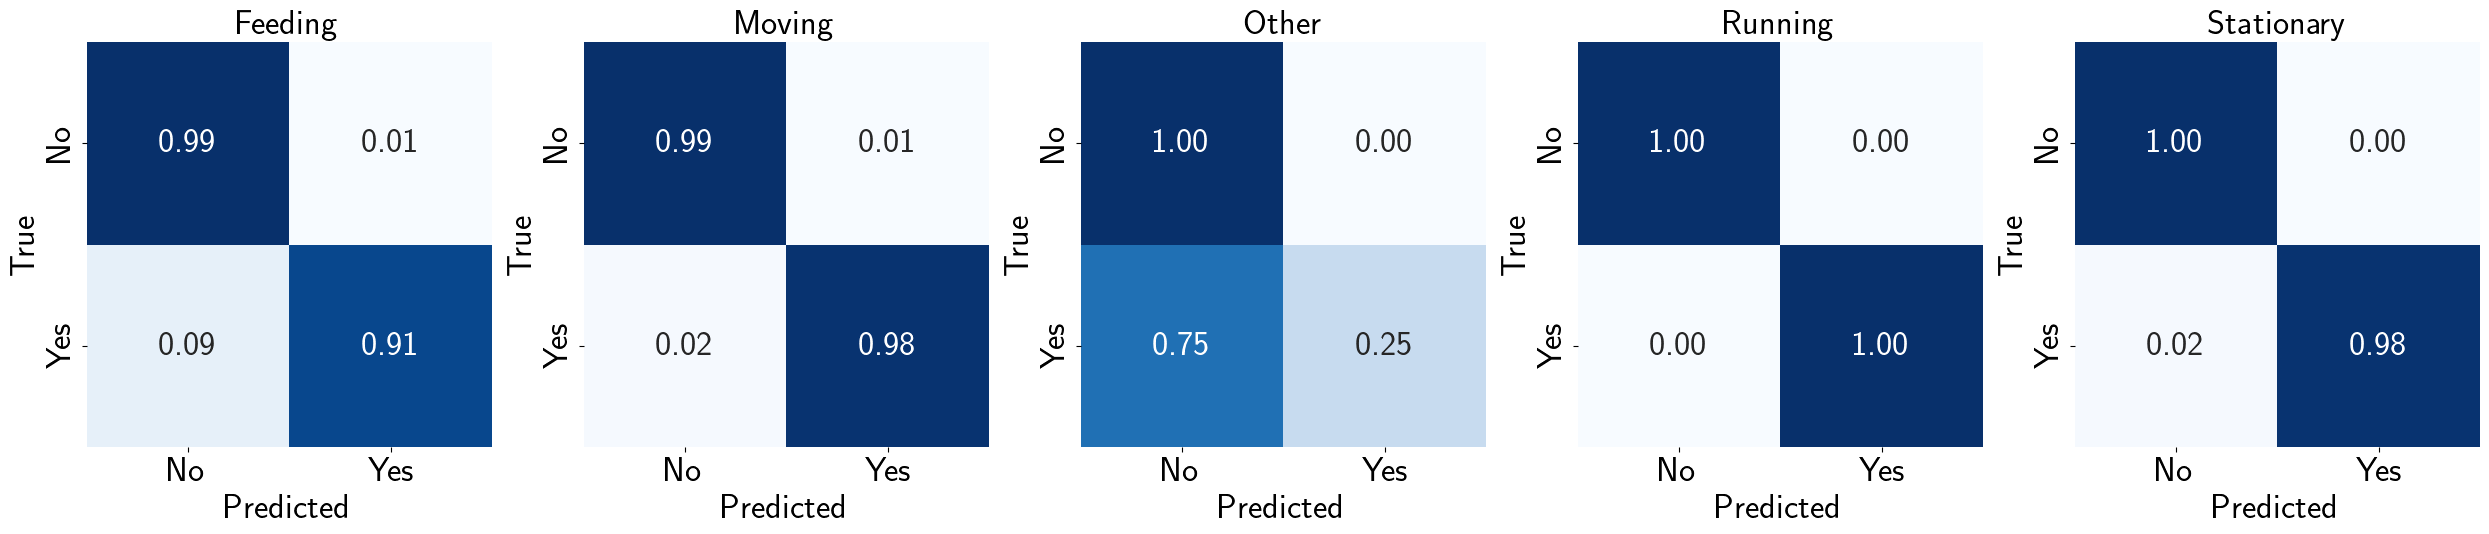

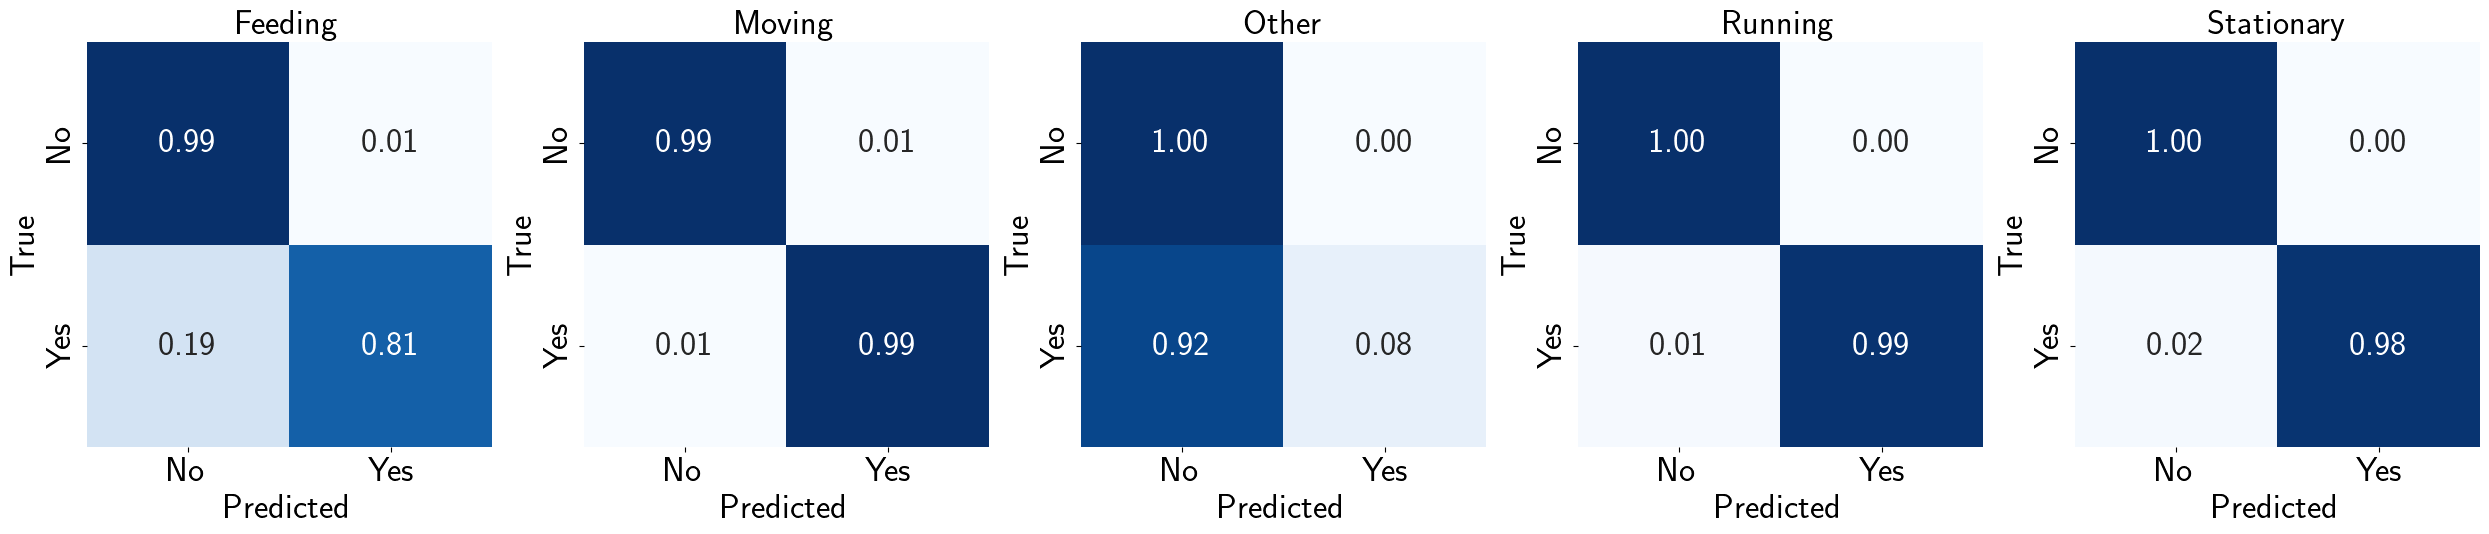

{}

In [23]:
dir1 = os.path.join(root_dir, "target1")
dir2 = os.path.join(root_dir, "target2")

multi_label_predictions(dir1, label_encoder, split='val', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='val', plot_confusion=True, return_precision=False)

Plotting confusion matrices for the two models on held-out validation set of the target data.

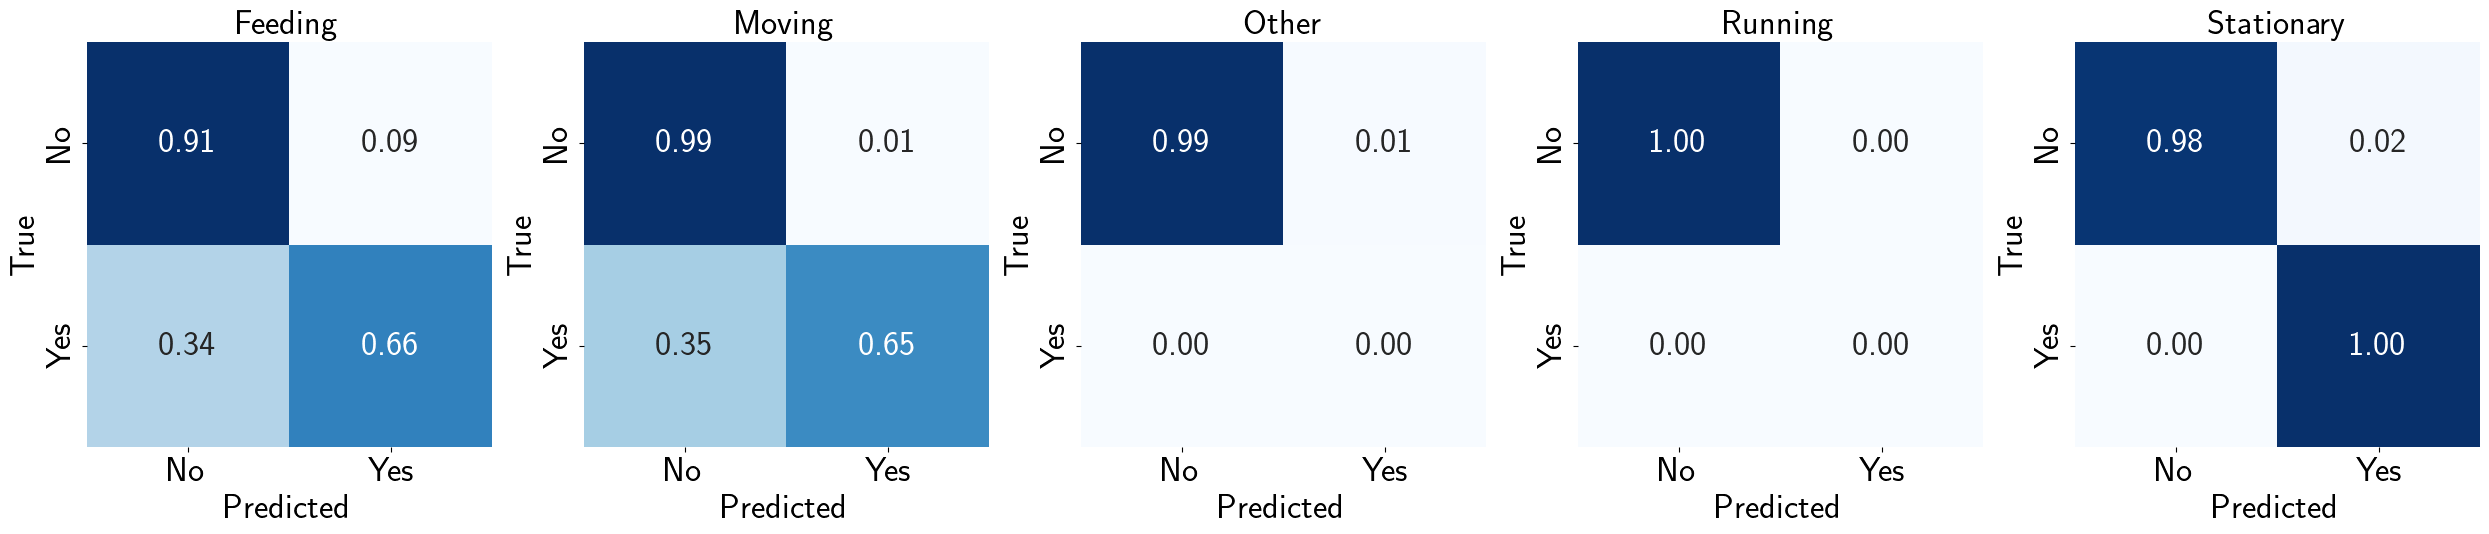

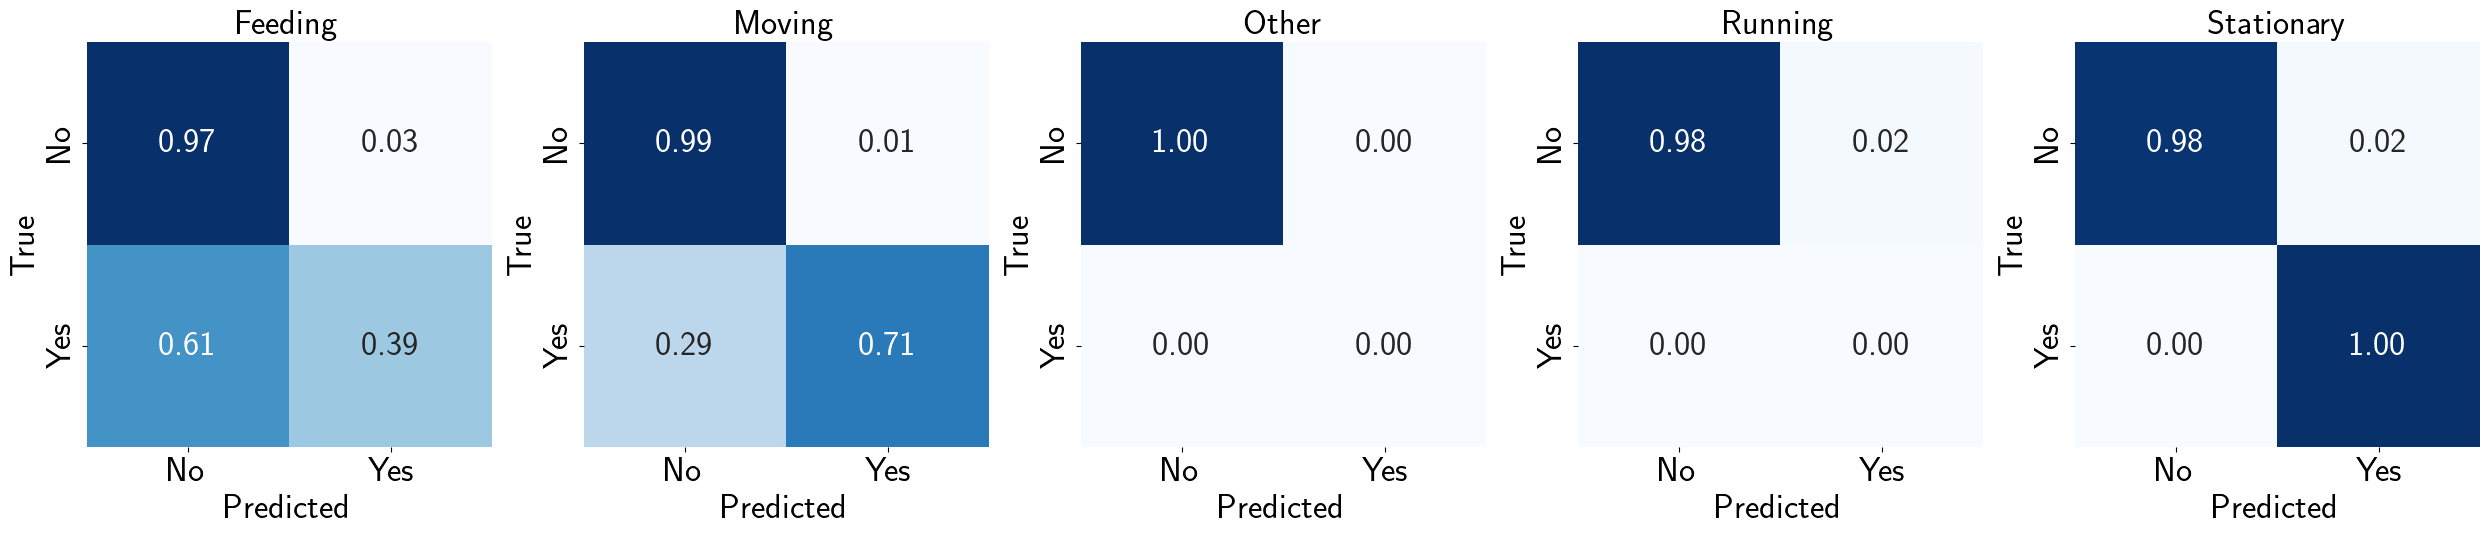

{}

In [24]:
multi_label_predictions(dir1, label_encoder, split='target_val', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='target_val', plot_confusion=True, return_precision=False)

Plotting confusion matrices for the two models on the entire (weakly) labeled target data belong to the respective sensor version.

/tmp/ipykernel_89781/701225943.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(dir_path, 'model.pt'), map_location=device)


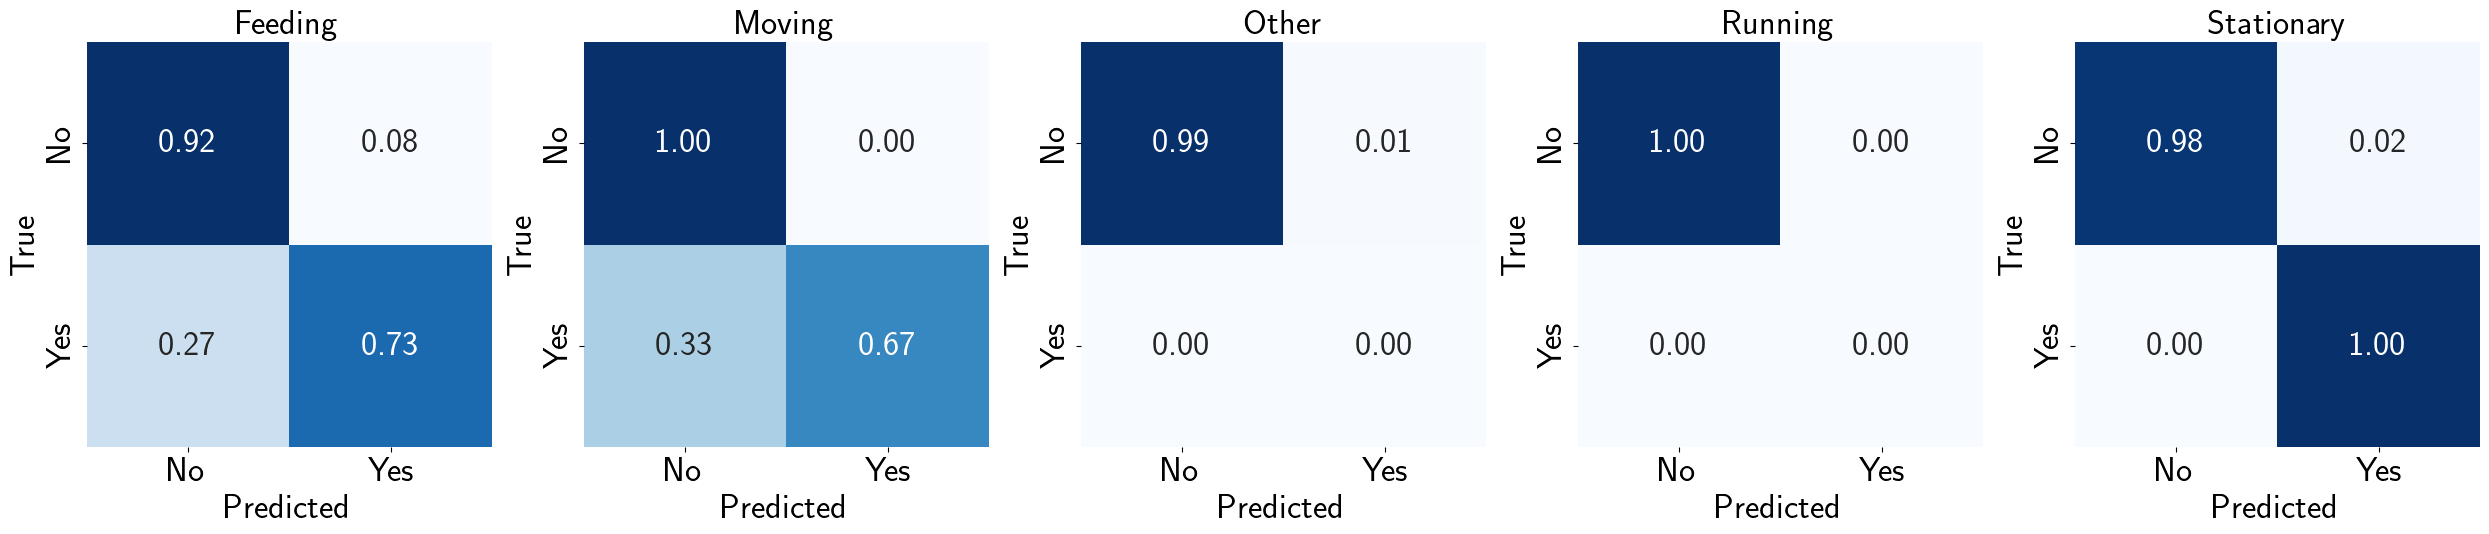

/tmp/ipykernel_89781/701225943.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(dir_path, 'model.pt'), map_location=device)


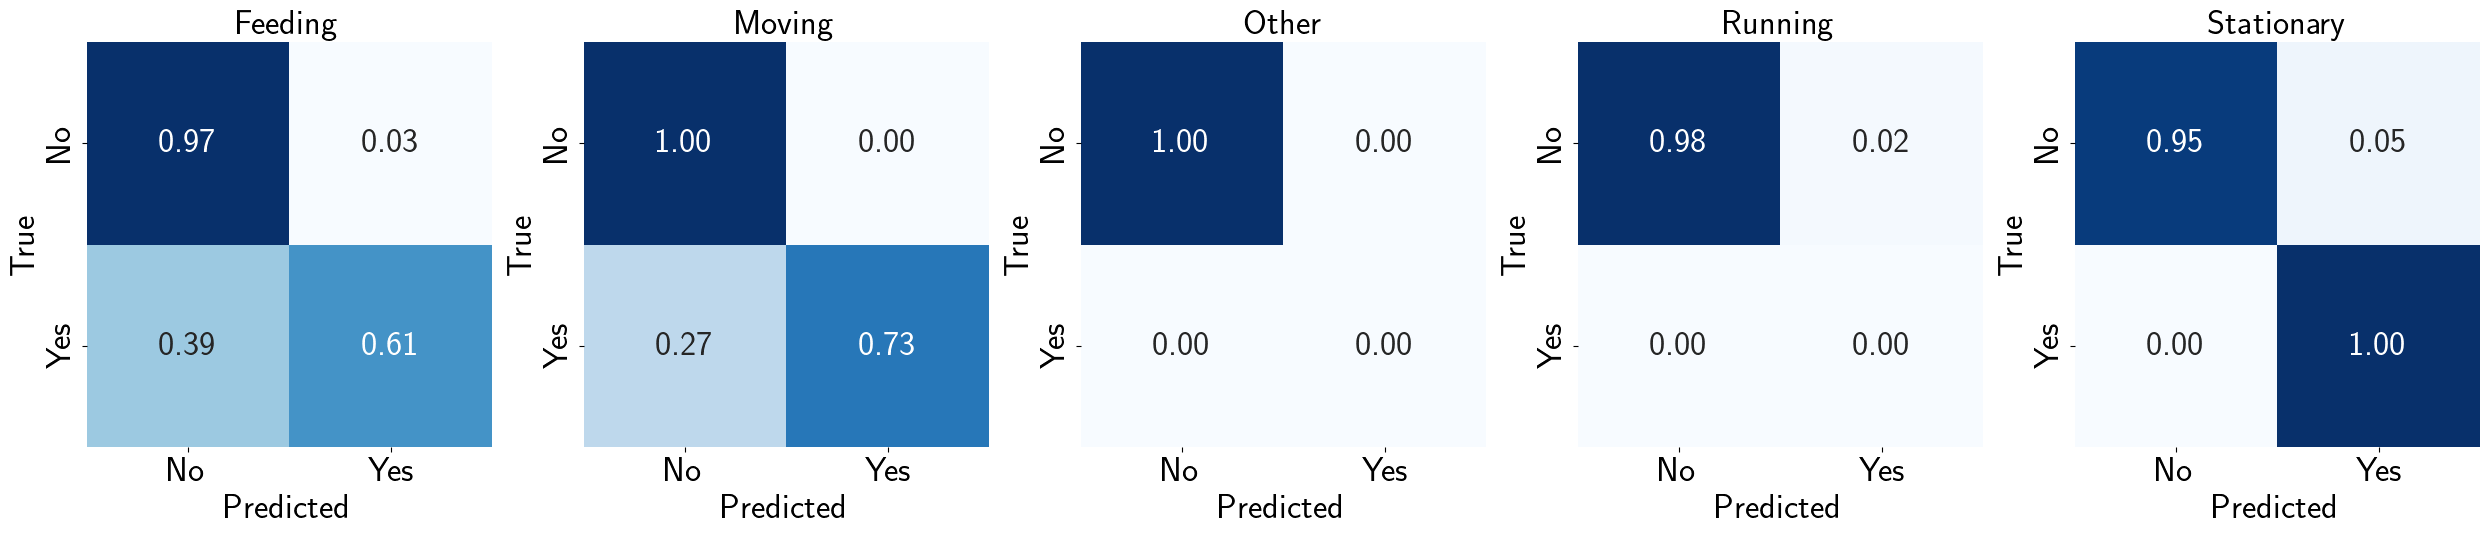

In [ ]:
for i, dir_path in enumerate([dir1, dir2]):
    
    fixmatch_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    fixmatch_model.load_state_dict(
        torch.load(os.path.join(dir_path, 'model.pt'), map_location=device)
    )
    fixmatch_model.to(device)

    mask_fw = (RVC_labeled_df.firmware_major_version == (i+2))
    Xt = transform(torch.tensor(RVC_labeled_df.loc[mask_fw, Vectronics_feature_cols].values, dtype=torch.float32))
    yt = RVC_labeled_df.loc[mask_fw, 'behavior'].values
    yt = np.eye(len(label_encoder.classes_))[label_encoder.transform(yt)]

    with torch.no_grad():
        _, logits = fixmatch_model(Xt.to(device))
        preds = torch.sigmoid(logits).detach().cpu().numpy()
        preds = (preds >= args.multilabel_threshold).astype(int)

    # Confusion matrices
    make_multilabel_confusion_matrices(
        y_true=yt, 
        y_pred=preds,
        label_encoder=label_encoder
    )

#### (2) Label Distribution

In [ ]:
for i, dir_path in enumerate([dir1, dir2]):
    fixmatch_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    fixmatch_model.to(device)
    print(f"Evaluating FixMatch model for target domain {i+1}...")

    print("PREDICTED SOURCE LABEL DISTRIBUTION:")
    all_pred_binary, all_probs, predicted_percent = evaluate_multilabel_distribution(model=fixmatch_model, 
                                data=transform(torch.tensor(X_src_full, dtype=torch.float32)),
                                label_encoder=label_encoder,
                                device=device, 
                                threshold=args.multilabel_threshold)

    Xt = RVC_df.loc[RVC_df.firmware_major_version == (i+2)][Vectronics_feature_cols].values
    print("PREDICTED TARGET LABEL DISTRIBUTION:")
    _, _, _ = evaluate_multilabel_distribution(model=fixmatch_model, 
                                    data=transform(torch.tensor(Xt, dtype=torch.float32)), 
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=args.multilabel_threshold)    

Evaluating FixMatch model for target domain 1...
PREDICTED SOURCE LABEL DISTRIBUTION:

Predicted class % occurrence:
  Feeding: 1.74%
  Moving: 7.43%
  Other: 3.98%
  Running: 1.46%
  Stationary: 82.13%
PREDICTED TARGET LABEL DISTRIBUTION:

Predicted class % occurrence:
  Feeding: 8.71%
  Moving: 32.01%
  Other: 1.22%
  Running: 0.33%
  Stationary: 51.64%
Evaluating FixMatch model for target domain 2...
PREDICTED SOURCE LABEL DISTRIBUTION:

Predicted class % occurrence:
  Feeding: 1.21%
  Moving: 13.56%
  Other: 0.15%
  Running: 1.23%
  Stationary: 79.90%
PREDICTED TARGET LABEL DISTRIBUTION:

Predicted class % occurrence:
  Feeding: 4.31%
  Moving: 26.90%
  Other: 0.14%
  Running: 1.52%
  Stationary: 60.17%


#### (3) ROC Curve

/tmp/ipykernel_1672324/895410501.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locati

Calibrating FixMatch model for target domain 1...


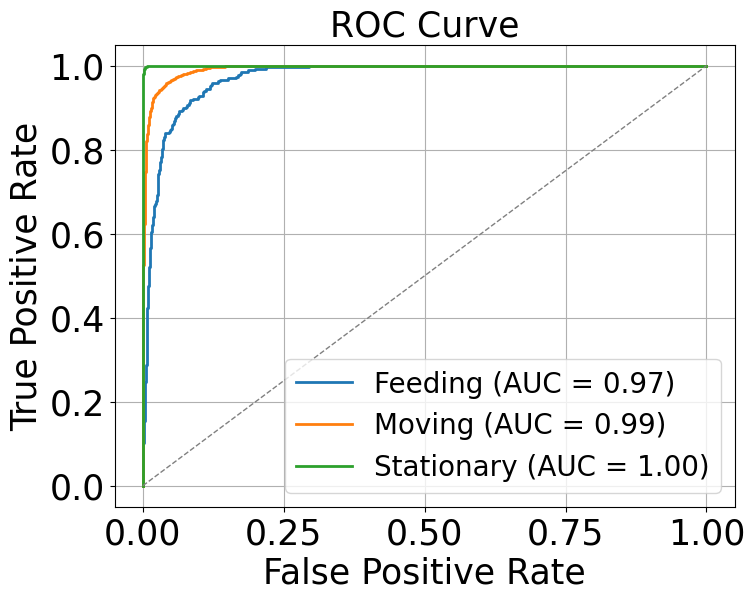

/tmp/ipykernel_1672324/895410501.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locati

Calibrating FixMatch model for target domain 2...


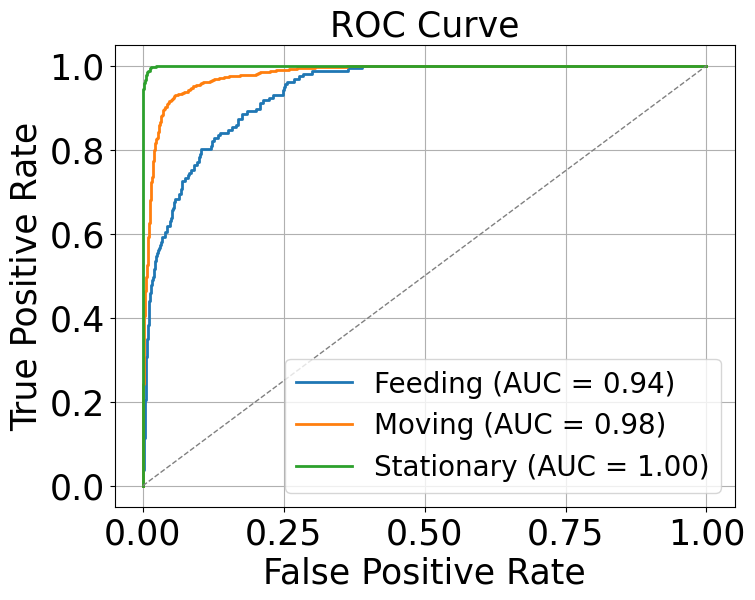

In [ ]:
for i, dir_path in enumerate([dir1, dir2]):
    fixmatch_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    fixmatch_model.to(device)
    print(f"Calibrating FixMatch model for target domain {i+1}...")

    target_test_predictions, target_test_weak_labels = [], []
    with torch.no_grad():
        for batch in target_labeled_test_loaders[i]:
            X, y = batch
            _, logits = fixmatch_model(torch.tensor(X, dtype=torch.float32).to(device))
            predictions = torch.sigmoid(logits).detach().cpu().numpy()
            target_test_predictions.append(predictions)
            target_test_weak_labels.append(y.cpu().numpy())

    # Stack predictions and labels appropriately
    all_predictions = np.vstack(target_test_predictions)   # rows = samples
    all_labels = np.argmax(np.vstack(target_test_weak_labels), axis=1)        # 1D array of labels

    plot_multiclass_roc(all_labels, all_predictions, label_encoder=label_encoder)

## STEP 4. Calibration

To correct the observed miscalibration, we apply a post-hoc **calibration procedure** that adjusts the predicted scores to match an ecologically reasonable **"golden" reference label distribution**.

### Calibration Procedure

1.  **Clustering:** K-Means clustering is performed on the target features to identify distinct feature regions, creating **$N=100$ clusters**.
2.  **Model Scoring:** The pre-trained FixMatch model scores are computed for the centroid of each cluster.
3.  **Distribution Alignment:** A calibration matrix is computed to adjust the cluster scores to align with a user-defined *ecological prior* (`label_dist`).

The user-defined "golden" label distribution used for calibration (representing an ecologically realistic prior) is:

$$\text{label\_dist} = [2.55, 4.48, 3.55, 1.96, 87.45]\%$$

*(Feeding, Moving, Other, Running, Stationary)*


In [27]:
Xt1 = transform(torch.tensor(RVC_df.loc[RVC_df.firmware_major_version == 2][Vectronics_feature_cols].values, dtype=torch.float32))
Xt2 = transform(torch.tensor(RVC_df.loc[RVC_df.firmware_major_version == 3][Vectronics_feature_cols].values, dtype=torch.float32))

uncalibrated_predictions = []
for i, (Xt, dir_path) in enumerate([(Xt1, dir1), (Xt2, dir2)]):

    fixmatch_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    fixmatch_model.to(device)
    
    with torch.no_grad():
        print(f"Evaluating FixMatch model for target domain {i+1}...")
        _, logits = fixmatch_model(Xt.to(device))
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        pred_df = pd.DataFrame(probs, columns=label_encoder.classes_)

    df = pd.concat(
        [RVC_df.loc[RVC_df.firmware_major_version == 2+i][RVC_preprocessing_config['helper_cols']].reset_index(drop=True),
         pred_df.reset_index(drop=True)],
        axis=1
    )
    
    uncalibrated_predictions.append(df)
    
uncalibrated_predictions = pd.concat(uncalibrated_predictions, axis=0).reset_index(drop=True).sort_values(by=['animal_id', 'UTC time [yyyy-mm-dd HH:MM:SS]']).reset_index(drop=True)
    

/tmp/ipykernel_89781/3778475780.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locatio

Evaluating FixMatch model for target domain 1...


/tmp/ipykernel_89781/3778475780.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locatio

Evaluating FixMatch model for target domain 2...


In [28]:
N_CLUSTERS, CLUSTER_BATCH_SIZE = 100, 1024
reg = 0.01

cluster_dist1, cluster_centroids1, cluster_labels1, kmeans1 = func.compute_kmeans_distribution(Xt1, 
                                                                                               n_clusters=N_CLUSTERS, 
                                                                                               batch_size=CLUSTER_BATCH_SIZE, 
                                                                                               random_state=42)
cluster_dist2, cluster_centroids2, cluster_labels2, kmeans2 = func.compute_kmeans_distribution(Xt2, 
                                                                                               n_clusters=N_CLUSTERS, 
                                                                                               batch_size=CLUSTER_BATCH_SIZE, 
                                                                                               random_state=42)
label_dist = np.array([2.55, 4.48, 3.55, 1.96, 87.45])

In [29]:
fixmatch_model1 = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
fixmatch_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=device))
fixmatch_model1.to(device)

fixmatch_model2 = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
fixmatch_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
fixmatch_model2.to(device)

calibration1_results = calibration(cluster_dist1, cluster_centroids1, cluster_labels1, fixmatch_model1, label_dist=label_dist, reg=reg)
calibration2_results = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, fixmatch_model2, label_dist=label_dist, reg=reg)

calibrated_predictions = []
adjusted_scores1 = calibration1_results['adjusted_scores'][cluster_labels1]
df = pd.concat(
        [RVC_df.loc[RVC_df.firmware_major_version == 2][RVC_preprocessing_config['helper_cols']].reset_index(drop=True),
         pd.DataFrame(adjusted_scores1, columns=label_encoder.classes_).reset_index(drop=True)],
        axis=1
    )
calibrated_predictions.append(df)

adjusted_scores2 = calibration2_results['adjusted_scores'][cluster_labels2]
df = pd.concat(
        [RVC_df.loc[RVC_df.firmware_major_version == 3][RVC_preprocessing_config['helper_cols']].reset_index(drop=True),
         pd.DataFrame(adjusted_scores2, columns=label_encoder.classes_).reset_index(drop=True)],
        axis=1
    )
calibrated_predictions.append(df)
calibrated_predictions = pd.concat(calibrated_predictions, axis=0).reset_index(drop=True).sort_values(by=['animal_id', 'UTC time [yyyy-mm-dd HH:MM:SS]']).reset_index(drop=True)


/tmp/ipykernel_89781/87265377.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=dev

/tmp/ipykernel_89781/2023655258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locatio

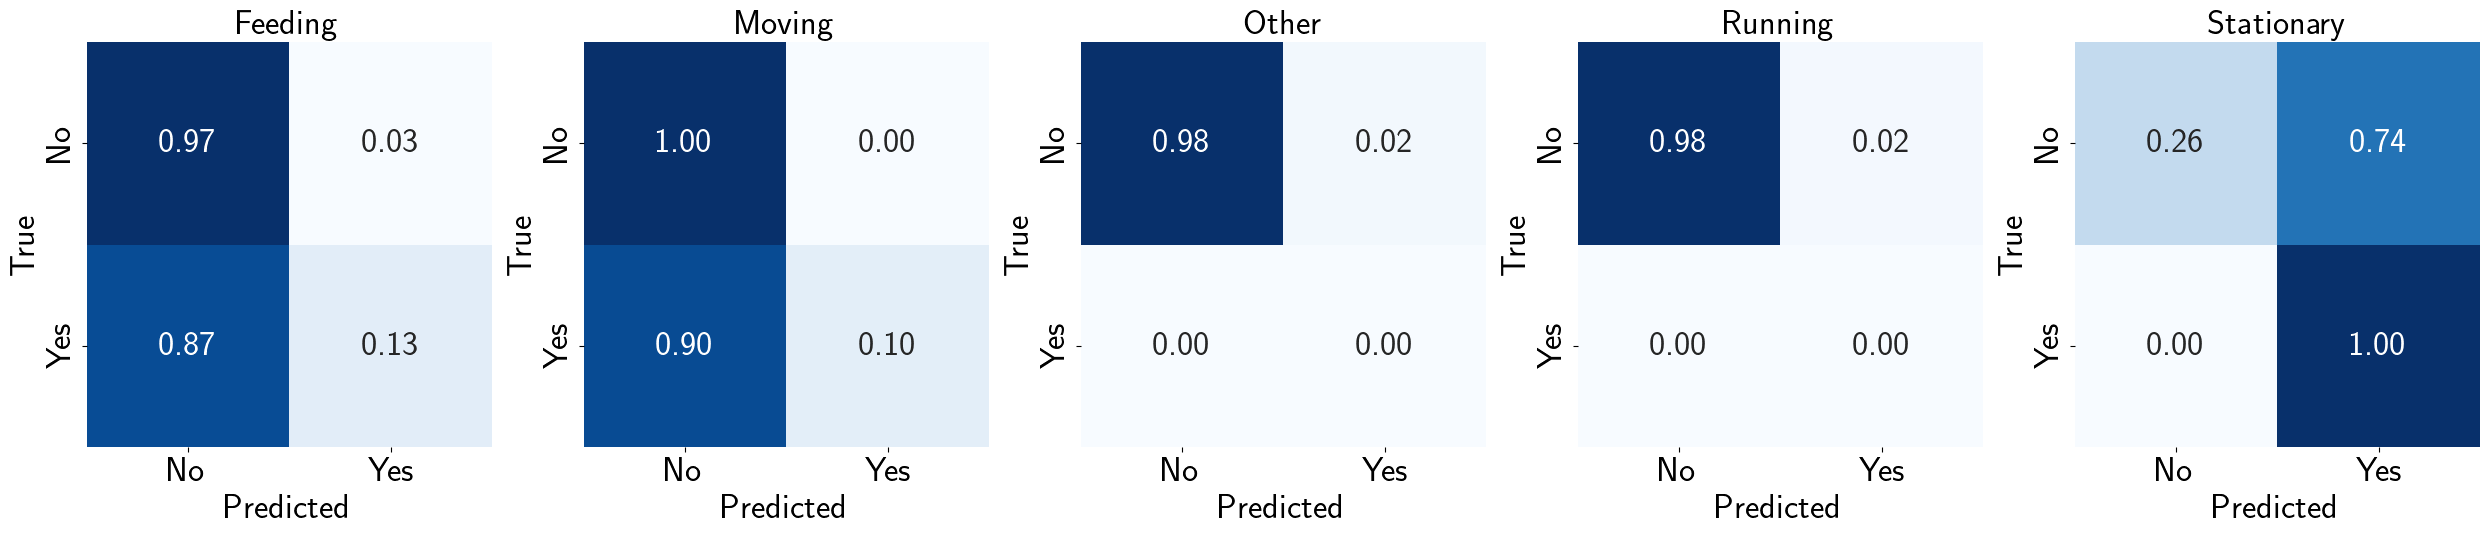

/tmp/ipykernel_89781/2023655258.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_locatio

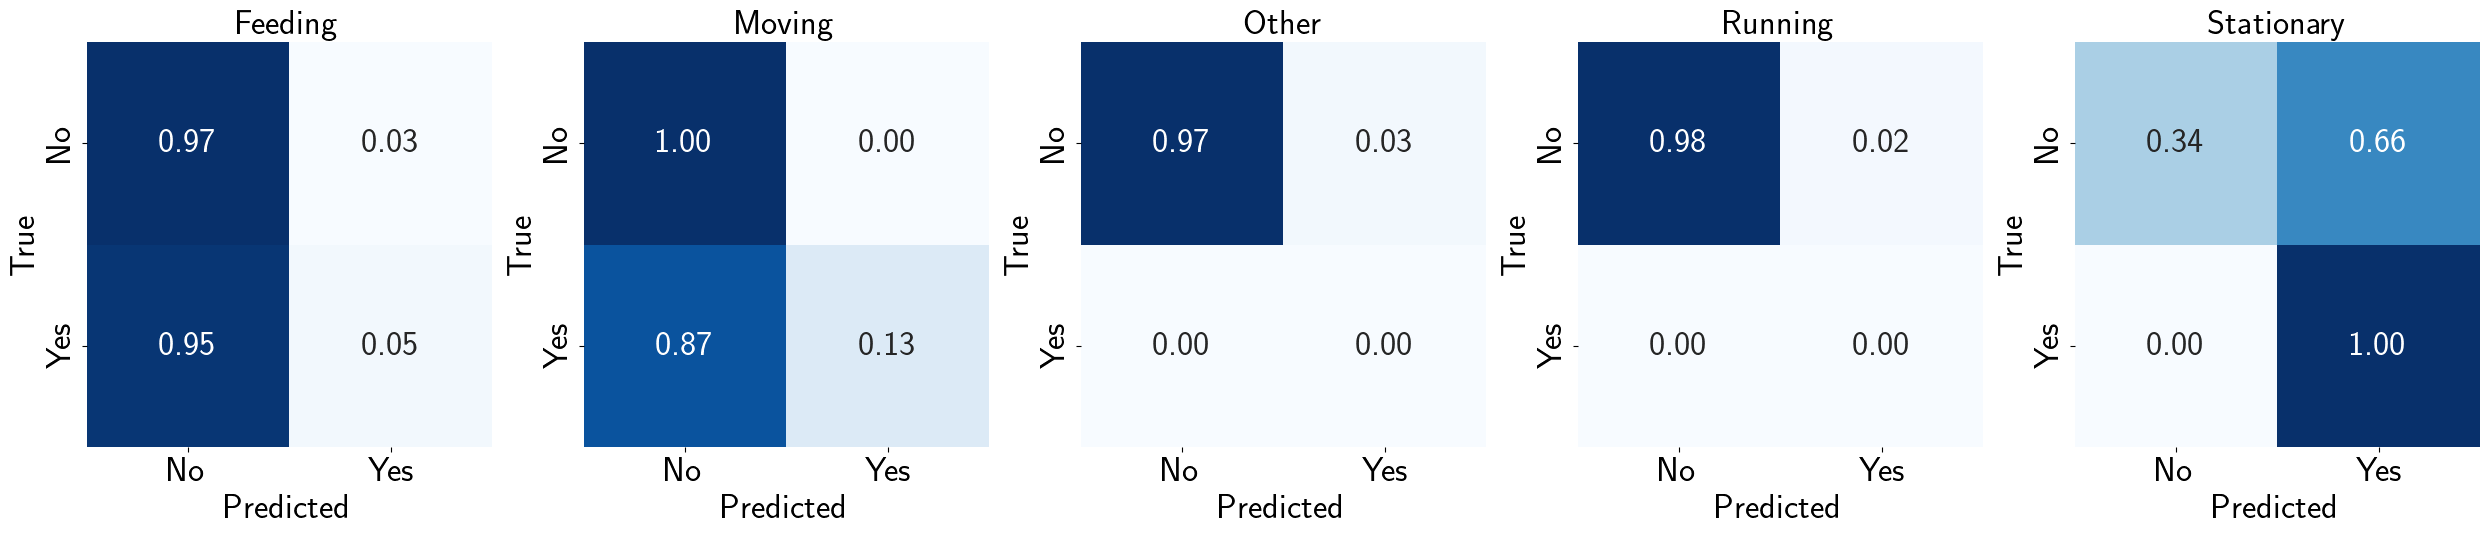

In [ ]:
for i, dir_path in enumerate([dir1, dir2]):
    fixmatch_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    fixmatch_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    fixmatch_model.to(device)
    
    Xt, yt = RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)][Vectronics_feature_cols].values, RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)]['behavior'].values
    Xt = transform(torch.tensor(Xt, dtype=torch.float32))
    yt = np.eye(len(label_encoder.classes_))[label_encoder.transform(yt)]

    cluster_labels = kmeans1.predict(Xt) if i==0 else kmeans2.predict(Xt)
    adjusted_scores = calibration1_results['adjusted_scores'][cluster_labels] if i==0 else calibration2_results['adjusted_scores'][cluster_labels]
    predictions = (adjusted_scores >= args.multilabel_threshold).astype(int)
    make_multilabel_confusion_matrices(y_true=yt, 
                                    y_pred=predictions,
                                    label_encoder=label_encoder)



/tmp/ipykernel_89781/1840173329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=d

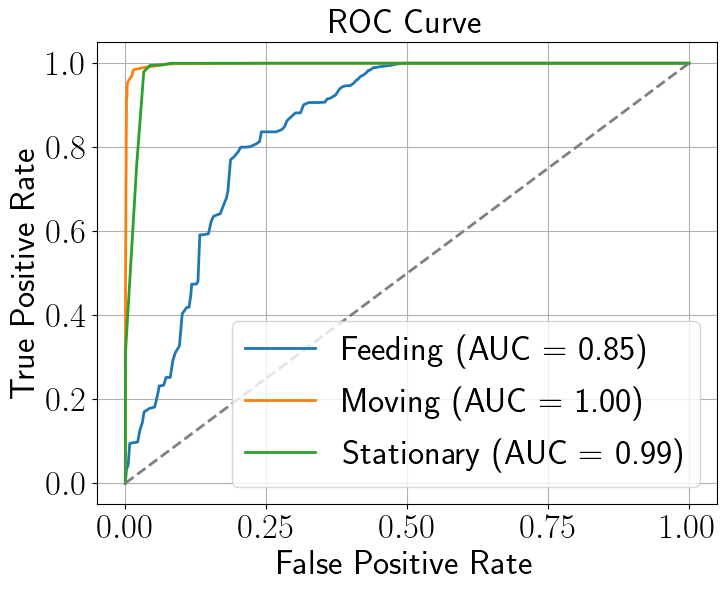

/tmp/ipykernel_89781/1840173329.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=d

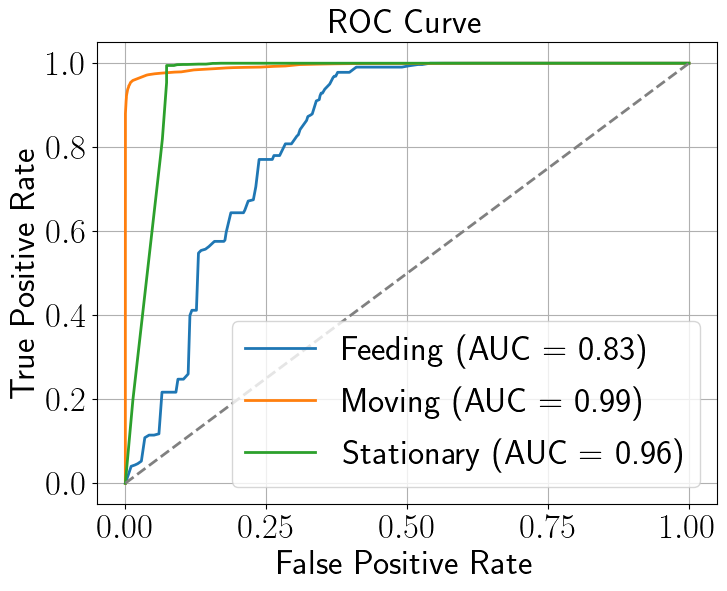

In [31]:
for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], args.feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)
    
    Xt, yt = RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)][Vectronics_feature_cols].values, RVC_labeled_df.loc[RVC_labeled_df.firmware_major_version == (i+2)]['behavior'].values
    Xt = transform(torch.tensor(Xt, dtype=torch.float32))
    yt = label_encoder.transform(yt)

    cluster_labels = kmeans1.predict(Xt) if i==0 else kmeans2.predict(Xt)
    adjusted_scores = calibration1_results['adjusted_scores'][cluster_labels] if i==0 else calibration2_results['adjusted_scores'][cluster_labels]
    plot_multiclass_roc(yt, adjusted_scores, label_encoder=label_encoder)

## STEP 5. Prediction and saving outputs

Saving the uncalibrated and calibrated prediction scores for each target distribution.

In [ ]:
uncalibrated_predictions['behavior_pred'] = (uncalibrated_predictions[label_encoder.classes_].values.argmax(axis=1))
uncalibrated_predictions['behavior_pred'] = label_encoder.inverse_transform(uncalibrated_predictions['behavior_pred'])
uncal_path = os.path.join(os.path.dirname(dir1), 'RVC_predictions_uncalibrated.csv')
uncalibrated_predictions.to_csv(uncal_path, index=False)
print(f"Saved concatenated uncalibrated predictions: {uncal_path}")

calibrated_predictions['behavior_pred'] = (calibrated_predictions[label_encoder.classes_].values.argmax(axis=1))
calibrated_predictions['behavior_pred'] = label_encoder.inverse_transform(calibrated_predictions['behavior_pred'])
cal_path = os.path.join(os.path.dirname(dir1), 'RVC_predictions_calibrated.csv')
calibrated_predictions.to_csv(cal_path, index=False)
print(f"Saved concatenated uncalibrated predictions: {cal_path}")

Saved concatenated uncalibrated predictions: /home/medhaaga/BotswanaML/results/domain_adaptation_training_results/fixmatch_semi_supervised/DEFAULT_20251214_165736/RVC_predictions_uncalibrated.csv
Saved concatenated uncalibrated predictions: /home/medhaaga/BotswanaML/results/domain_adaptation_training_results/fixmatch_semi_supervised/DEFAULT_20251214_165736/RVC_predictions_calibrated.csv


To verify that the accuracy of the uncalibarted and calibrated predictions that are finally saved, we plot the confusion matrix for the most-likely predictions using weak labels as the true classes.

/tmp/ipykernel_89781/4048983523.py:7: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)


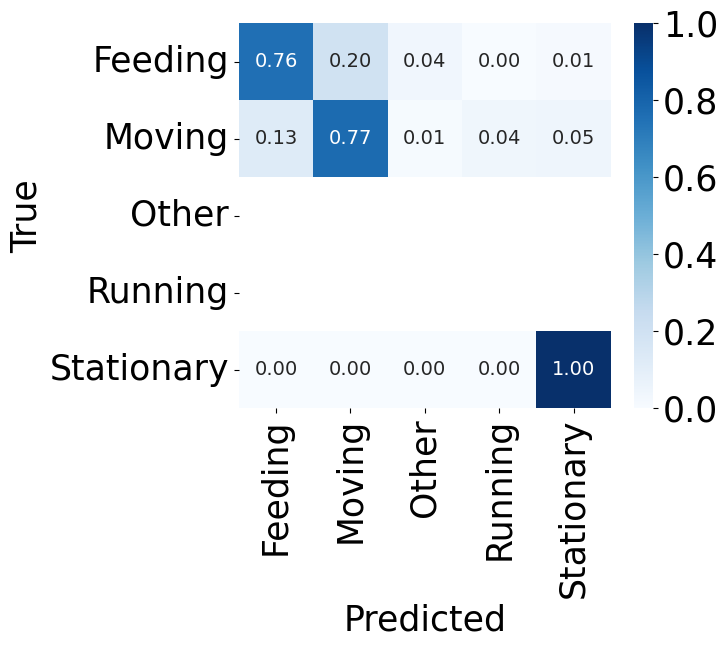

In [36]:
uncalibrated_predictions = uncalibrated_predictions.dropna(subset=['behavior']).copy()
cm = confusion_matrix(
    uncalibrated_predictions['behavior'],
    uncalibrated_predictions['behavior_pred'],
    labels=label_encoder.classes_
)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    vmin=0, vmax=1,
    annot_kws={"size": 14}
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/tmp/ipykernel_89781/3264214179.py:7: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)


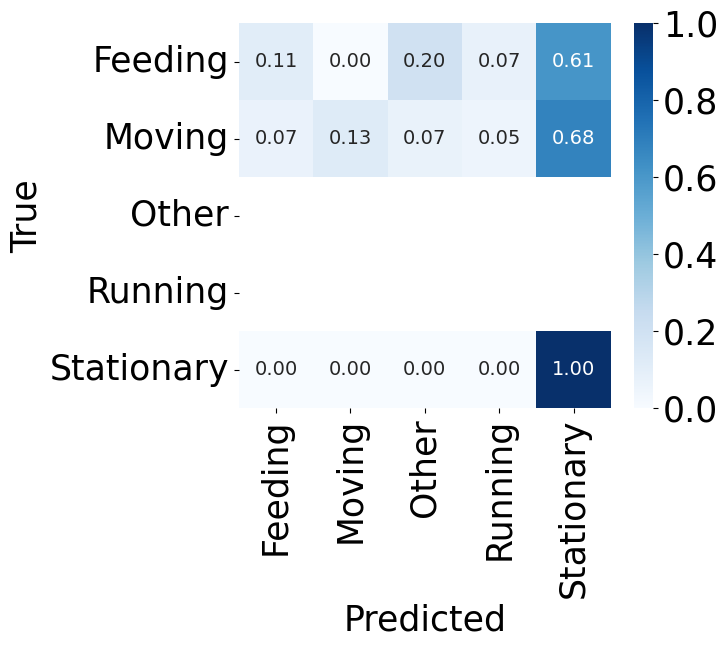

In [37]:
calibrated_predictions = calibrated_predictions.dropna(subset=['behavior']).copy()
cm = confusion_matrix(
    calibrated_predictions['behavior'],
    calibrated_predictions['behavior_pred'],
    labels=label_encoder.classes_
)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    vmin=0, vmax=1,
    annot_kws={"size": 14}
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
